# Aim: Understand performance of model sampling in a systematic way

In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))  # similar-expressions/
sys.path.insert(0, project_root)

# Reload modules
from importlib import reload
from src.model import encoder, decoder
from src.utils import dataset, config, dev, dataset_dev, parsing, grammar
reload(decoder); reload(encoder); reload(dataset); reload(config); reload(dev); reload(dataset_dev); reload(parsing); reload(grammar); reload(grammar)

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


<module 'data_util' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/model/data_util.py'>

In [23]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from matplotlib import pyplot as plt
from omegaconf import OmegaConf

from src.utils.dataset import load_dataset, create_dataloader, create_value_transform
from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader

torch.manual_seed(42)
torch.set_grad_enabled(False)


SIMILARITY_THRESHOLD = 0.2

In [39]:
# Load model and dataset
# Run 448: 81tqyqtr
# Run 469 (no sampling or KL): iqdrlm52
model, cfg = load_wandb_model(run='e51hcsb9', name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml', wandb_cache_path='/cephfs/store/gr-mc2473/lc865/workspace/wandb-cache')
cfg.training.dataset_len_limit = 2**15
train_loader, valid_loader, info = create_dataloader_from_wandb(cfg, datapath='/cephfs/store/gr-mc2473/lc865/workspace/data', allow_different_dataset_hash=True)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': None, 'scale': None}), None)


Imported model from run "e51hcsb9".
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | encoder | Encoder | 8.9 M  | eval
1 | decoder | Decoder | 8.6 M  | eval
-------------------------------------------
17.5 M    Trainable params
0         Non-trainable params
17.5 M    Total params
70.150    Total estimated model params size (MB)
0         Modules in train mode
78        Modules in eval mode
Using dataset "dataset_250110_2" of size 29492
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 29492   | Batch: 512   | Batches: 57   
  | valid        | Size: 3276    | Batch: 512   | Batches: 6    
---------------------------------------------------------------------


## 1. Encode, sample, decode and analyse result

Idea: Populate DF with all information and then apply filters for stats

In [36]:
from parsing import logits_to_infix, eval_from_logits
from tqdm.notebook import tqdm
tqdm().pandas()
import warnings
from wrapt_timeout_decorator import *

def calc_syntax_consts(logits):
    if logits is None:
        return pd.Series([None, None])
    
    syntax = torch.argmax(logits[:, :-1], dim=-1).detach().numpy()
    consts = logits[:, -1].detach().numpy()
    return pd.Series([syntax, consts])

@timeout(1)
def eval_from_logits_timeouted(*args, **kwargs):
    try:
        return eval_from_logits(*args, **kwargs)
    except TimeoutError:
        return None

@timeout(1)
def logits_to_infix_timeouted(*args, **kwargs):
    try:
        return logits_to_infix(*args, **kwargs)
    except TimeoutError:
        return None


def logits_to_infix_safe(logits):
    try:  # TODO: Stochastic decoding
        infix_raw = logits_to_infix_timeouted(logits, sample=False, replace_const='numerical_rounded', round_const_decimals=4)
        infix_no_const = logits_to_infix_timeouted(logits, sample=False, replace_const='nothing', round_const_decimals=4)
        sympy_expr = sp.sympify(infix_raw.lower())
        sympy_expr_no_const = sp.sympify(infix_no_const.lower())
        assert sp.Symbol('s') not in sympy_expr.free_symbols and sp.zoo not in sympy_expr.free_symbols
        success = True
    except Exception as e:
        infix_raw, infix_no_const, sympy_expr, sympy_expr_no_const = None, None, None, None
        success = False
    return pd.Series([infix_raw, infix_no_const, sympy_expr, sympy_expr_no_const, success])

def eval_logits_safe(logits):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res_raw = eval_from_logits_timeouted(logits, val_x.squeeze())
            res = res_raw.astype(np.float32)
        assert res.shape == (100,)
        success = True
    except Exception as e:
        res = None
        success = False
    return pd.Series([res, success])

def transform_and_check_diffs(val_y):
    if val_y is None:
        return pd.Series([False, None])
    values_pred = value_transform(torch.tensor(val_y).unsqueeze(0)).detach().numpy()  # value_transform requires batch dimension
    first_derivative = np.diff(values_pred, axis=1) / np.diff(val_x, axis=0).T
    second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
    third_derivative = np.diff(second_derivative, axis=1) / np.diff(val_x[:-2], axis=0).T
    fourth_derivative = np.diff(third_derivative, axis=1) / np.diff(val_x[:-3], axis=0).T
    is_valid = (np.all(np.abs(first_derivative) < 2e2, axis=1) & \
                np.all(np.abs(second_derivative) < 2e2, axis=1) & \
                np.all(np.abs(third_derivative) < 2e2, axis=1) & \
                np.all(np.abs(fourth_derivative) < 2e2, axis=1) & \
                np.all(np.abs(values_pred) < 10, axis=1))
    return pd.Series([is_valid[0], values_pred[0]])  # Rm batch dim

def calc_similarity(val_transformed, val_orig):
    # val_y: Transformed
    if val_transformed is None:
        return pd.Series([None, False])  # MSE, is_simmilar
    
    mse = np.mean((val_transformed - val_orig.squeeze().detach().numpy()) ** 2)
    return pd.Series([mse, mse < SIMILARITY_THRESHOLD])

def create_df(logits_neigh, val_orig, source_infix_no_const, source_sympy_expr_no_const):
    df = pd.DataFrame({'logits': [logits_neigh[j] for j in range(len(logits_neigh))]})
    df[['syntax', 'consts']] = df['logits'].apply(calc_syntax_consts)
    df['syntax_str'] = df.syntax.apply(lambda x: ','.join(x.astype(str)))
    df[['infix', 'infix_no_const', 'sympy_expr', 'sympy_expr_no_const', 'infix_success']] = df['logits'].apply(logits_to_infix_safe)
    df['sympy_expr_simplified_no_const'] = df['sympy_expr'].apply(lambda x: replace_numbers_with_symbols(x))
    df[['val_y', 'eval_success']] = df['logits'].apply(eval_logits_safe)
    df[['is_valid', 'val_transformed']] = df['val_y'].apply(transform_and_check_diffs)
    df[['mse', 'is_similar']] = df['val_transformed'].apply(calc_similarity, val_orig=val_orig)
    df['is_novel_skeleton'] = df['infix_no_const'].apply(lambda x: x != source_infix_no_const)
    df['is_novel_skeleton_simplified'] = df['sympy_expr_simplified_no_const'].apply(lambda x: str(x) != str(source_sympy_expr_no_const).lower())
    return df

def calc_stats(df):
    x10 = 10
    x100 = 100
    mask_novel_sim = (df.is_valid & df.is_novel_skeleton & df.is_similar)
    mask_novel_x10 = (df.is_valid & df.is_novel_skeleton & (df.mse < SIMILARITY_THRESHOLD * x10))
    mask_novel_x100 = (df.is_valid & df.is_novel_skeleton & (df.mse < SIMILARITY_THRESHOLD * x100))

    stats = {
        'total': len(df),
        'infix_success': df.infix_success.sum(),
        'eval_success': df.eval_success.sum(),
        'infix_and_eval_success': (df.infix_success & df.eval_success).sum(),
        'valid': df.is_valid.sum(),
        'novel_skeleton': df.is_novel_skeleton.sum(),
        'novel_skeleton_simplified': df.is_novel_skeleton_simplified.sum(),
        'similar': df.is_similar.sum(),
        'valid_novel_skeleton': (df.is_valid & df.is_novel_skeleton).sum(),
        'valid_novel_skeleton_simplified': (df.is_valid & df.is_novel_skeleton_simplified).sum(),
        'valid_similar': (df.is_valid & df.is_similar).sum(),
        'novel_skeleton_similar': mask_novel_sim.sum(),
        'novel_skeleton_simx10': mask_novel_x10.sum(),
        'novel_skeleton_simx100': mask_novel_x100.sum(),
        'novel_skeleton_similar_unique': df.infix_no_const[mask_novel_sim & df.infix_no_const.notna()].nunique(),
        'novel_skeleton_simx10_unique': df.infix_no_const[mask_novel_x10 & df.infix_no_const.notna()].nunique(),
        'novel_skeleton_simx100_unique': df.infix_no_const[mask_novel_x100 & df.infix_no_const.notna()].nunique(),
        'novel_skeleton_similar_unique_simplified': df.sympy_expr_simplified_no_const[mask_novel_sim & df.sympy_expr_simplified_no_const.notna()].apply(str).nunique(),
        'novel_skeleton_simx10_unique_simplified': df.sympy_expr_simplified_no_const[mask_novel_x10 & df.sympy_expr_simplified_no_const.notna()].apply(str).nunique(),
        'novel_skeleton_simx100_unique_simplified': df.sympy_expr_simplified_no_const[mask_novel_x100 & df.sympy_expr_simplified_no_const.notna()].apply(str).nunique(),
        'old_skeleton_similar': (~df.is_novel_skeleton & df.is_similar).sum(),
        'old_skeleton_simx10': (~df.is_novel_skeleton & (df.mse < SIMILARITY_THRESHOLD * x10)).sum(),
        'old_skeleton_simx100': (~df.is_novel_skeleton & (df.mse < SIMILARITY_THRESHOLD * x100)).sum(),
        'unique_exprs': df.infix_no_const[df.infix_no_const.notna()].nunique(),
        'unique_exprs_simplified': df.sympy_expr_simplified_no_const[df.sympy_expr_simplified_no_const.notna()].apply(str).nunique(),
    }
    return stats

def replace_numbers_with_symbols(expr, symbol_str='con'):
    if expr is None:
        return None
    
    sym = sp.Symbol(symbol_str)
    if isinstance(expr, (sp.core.numbers.Number, sp.core.numbers.Float, sp.core.numbers.Integer, sp.Symbol)):
        return sym
    
    a = expr.copy()
    for atom in list(expr.atoms()):
        if atom.is_number:
            a = a.replace(atom, sym)
    return a

0it [00:00, ?it/s]

Original: -con + exp(x1)


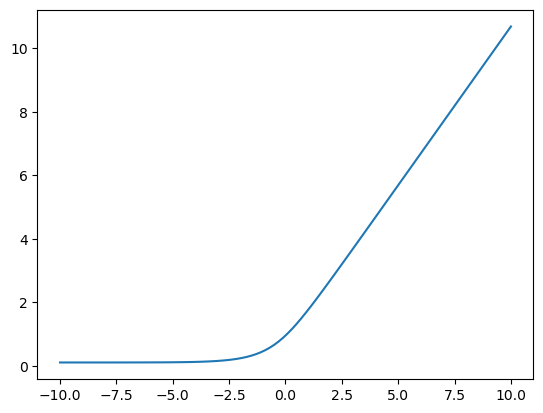

total: 100
infix_success: 77
eval_success: 71
infix_and_eval_success: 71
valid: 33
novel_skeleton: 100
novel_skeleton_simplified: 100
similar: 2
valid_novel_skeleton: 33
valid_novel_skeleton_simplified: 33
valid_similar: 0
novel_skeleton_similar: 0
novel_skeleton_simx10: 0
novel_skeleton_simx100: 22
novel_skeleton_similar_unique: 0
novel_skeleton_simx10_unique: 0
novel_skeleton_simx100_unique: 22
novel_skeleton_similar_unique_simplified: 0
novel_skeleton_simx10_unique_simplified: 0
novel_skeleton_simx100_unique_simplified: 14
old_skeleton_similar: 0
old_skeleton_simx10: 0
old_skeleton_simx100: 0
unique_exprs: 77
unique_exprs_simplified: 50


/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [53]:
i = 16
n_samples = 100
var = 1  # Use standard model output
model.sampling_eps = 0.05   # <- Change this
data_loader = valid_loader

val_orig = data_from_loader(data_loader, 'values', idx=i)
x = data_from_loader(data_loader, 'x', idx=i)
tmp = x.squeeze().detach().numpy()
source_syntax = np.argmax(tmp[:, :-1], axis=-1)
source_consts = tmp[:, -1]
source_syntax, source_consts
source_infix_no_const = logits_to_infix(x.squeeze(), sample=False, replace_const="nothing")
source_infix = logits_to_infix(x.squeeze(), sample=False, replace_const="numerical")
source_sympy_expr = sp.sympify(source_infix.lower())
source_sympy_expr_no_const = replace_numbers_with_symbols(source_sympy_expr)

mean, ln_var = model.encoder(x)
z = model.sample(mean.repeat(n_samples, 1), torch.tensor(var).log().repeat(n_samples, 1))
logits_neigh = model.decoder(z)

print(f'Original: {sp.sympify(source_infix_no_const.lower())}')
plt.plot(val_x.squeeze(), val_orig.squeeze().detach().numpy(), label='Original')
plt.show()

df = create_df(logits_neigh, val_orig, source_infix_no_const, source_sympy_expr_no_const)

stats = calc_stats(df)
for k, v in stats.items():
    print(f'{k}: {v}')

In [51]:
mask = (df.is_valid & df.is_novel_skeleton & (df.mse < SIMILARITY_THRESHOLD))
assert np.any(mask), 'No similar and novel skeletons found'
plt.plot(val_x.squeeze(), np.stack(df[mask].val_transformed.values).T, label='Generated')
plt.plot(val_x.squeeze(), val_orig.squeeze().detach().numpy(), label='Original', linestyle='--')
plt.legend()
plt.show()

AssertionError: No similar and novel skeletons found

In [48]:
print(f'Original: {sp.sympify(logits_to_infix(x.squeeze(), sample=False, replace_const="numerical_rounded").lower())}')

pd.set_option('display.max_colwidth', 1000)
df[['sympy_expr', 'infix']][mask]

Original: -x1**2 + 2*x1


,sympy_expr,infix
33,-1.2632*x1**2 + 1.853*x1 - 0.399249295553543,(x1-(1.2632*(x1*x1)))+((0.853*x1)-SQRT(0.1594))


### 1.2 Robust sampling performance metrics

In [82]:
from tqdm.notebook import trange
n_samples = 100
var = 1
model.sampling_eps = 0.02
dataloader = valid_loader   


all_stats = []
for i in trange(20):
    val_orig = data_from_loader(data_loader, 'values', idx=i)
    x = data_from_loader(data_loader, 'x', idx=i)
    tmp = x.squeeze().detach().numpy()
    source_syntax = np.argmax(tmp[:, :-1], axis=-1)
    source_consts = tmp[:, -1]
    source_syntax, source_consts
    source_infix_no_const = logits_to_infix(x.squeeze(), sample=False, replace_const="nothing")
    source_infix = logits_to_infix(x.squeeze(), sample=False, replace_const="numerical")
    source_sympy_expr = sp.sympify(source_infix.lower())
    source_sympy_expr_no_const = replace_numbers_with_symbols(source_sympy_expr)
    
    mean, ln_var = model.encoder(x)
    z = model.sample(mean.repeat(n_samples, 1), torch.tensor(var).log().repeat(n_samples, 1))
    logits_neigh = model.decoder(z)

    df = create_df(logits_neigh, val_orig, source_infix_no_const, source_sympy_expr_no_const)
    all_stats.append(calc_stats(df))
    
# Calculate mean stats across all runs
mean_stats = {}
for key in all_stats[0].keys():
    values = [s[key] for s in all_stats]
    mean_stats[key] = np.mean(values)

print("Mean statistics across runs:")
for k, v in mean_stats.items():
    print(f"{k}: {v}")


  0%|          | 0/20 [00:00<?, ?it/s]

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtr

Mean statistics across runs:
total: 100.0
infix_success: 97.65
eval_success: 89.85
infix_and_eval_success: 89.8
valid: 59.0
novel_skeleton: 75.3
novel_skeleton_simplified: 65.4
similar: 26.7
valid_novel_skeleton: 38.7
valid_novel_skeleton_simplified: 30.55
valid_similar: 24.25
novel_skeleton_similar: 8.7
novel_skeleton_simx10: 18.85
novel_skeleton_simx100: 32.65
novel_skeleton_similar_unique: 8.25
novel_skeleton_simx10_unique: 17.35
novel_skeleton_simx100_unique: 29.45
novel_skeleton_similar_unique_simplified: 4.2
novel_skeleton_simx10_unique_simplified: 9.25
novel_skeleton_simx100_unique_simplified: 16.0
old_skeleton_similar: 16.9
old_skeleton_simx10: 19.95
old_skeleton_simx100: 21.6
unique_exprs: 68.25
unique_exprs_simplified: 41.85


### Model: e51hcsb9


In [85]:
raw1 = """
sampling_eps:0.01
total: 100.0
infix_success: 99.75
eval_success: 99.2
infix_and_eval_success: 99.2
valid: 83.85
novel_skeleton: 9.0
novel_skeleton_simplified: 5.65
similar: 82.7
valid_novel_skeleton: 5.85
valid_novel_skeleton_simplified: 2.75
valid_similar: 77.65
novel_skeleton_similar: 4.1
novel_skeleton_simx10: 4.85
novel_skeleton_simx100: 5.7
novel_skeleton_similar_unique: 2.4
novel_skeleton_simx10_unique: 3.0
novel_skeleton_simx100_unique: 3.5
novel_skeleton_similar_unique_simplified: 1.15
novel_skeleton_simx10_unique_simplified: 1.55
novel_skeleton_simx100_unique_simplified: 2.0
old_skeleton_similar: 78.3
old_skeleton_simx10: 82.2
old_skeleton_simx100: 82.75
unique_exprs: 6.35
unique_exprs_simplified: 4.1
"""

raw6 = """
sampling_eps:0.02
total: 100.0
infix_success: 97.65
eval_success: 89.85
infix_and_eval_success: 89.8
valid: 59.0
novel_skeleton: 75.3
novel_skeleton_simplified: 65.4
similar: 26.7
valid_novel_skeleton: 38.7
valid_novel_skeleton_simplified: 30.55
valid_similar: 24.25
novel_skeleton_similar: 8.7
novel_skeleton_simx10: 18.85
novel_skeleton_simx100: 32.65
novel_skeleton_similar_unique: 8.25
novel_skeleton_simx10_unique: 17.35
novel_skeleton_simx100_unique: 29.45
novel_skeleton_similar_unique_simplified: 4.2
novel_skeleton_simx10_unique_simplified: 9.25
novel_skeleton_simx100_unique_simplified: 16.0
old_skeleton_similar: 16.9
old_skeleton_simx10: 19.95
old_skeleton_simx100: 21.6
unique_exprs: 68.25
unique_exprs_simplified: 41.85
"""

raw2 = """
sampling_eps:0.05
total: 100.0
infix_success: 86.95
eval_success: 76.55
infix_and_eval_success: 76.55
valid: 35.55
novel_skeleton: 99.95
novel_skeleton_simplified: 97.8
similar: 2.15
valid_novel_skeleton: 35.5
valid_novel_skeleton_simplified: 33.45
valid_similar: 1.6
novel_skeleton_similar: 1.55
novel_skeleton_simx10: 9.15
novel_skeleton_simx100: 29.3
novel_skeleton_similar_unique: 1.55
novel_skeleton_simx10_unique: 9.15
novel_skeleton_simx100_unique: 29.3
novel_skeleton_similar_unique_simplified: 1.15
novel_skeleton_simx10_unique_simplified: 6.85
novel_skeleton_simx100_unique_simplified: 20.1
old_skeleton_similar: 0.05
old_skeleton_simx10: 0.05
old_skeleton_simx100: 0.05
unique_exprs: 86.8
unique_exprs_simplified: 62.6
"""

raw3 = """
sampling_eps:0.1
total: 100.0
infix_success: 71.6
eval_success: 56.45
infix_and_eval_success: 56.35
valid: 24.95
novel_skeleton: 99.95
novel_skeleton_simplified: 98.8
similar: 1.05
valid_novel_skeleton: 24.9
valid_novel_skeleton_simplified: 24.0
valid_similar: 1.0
novel_skeleton_similar: 0.95
novel_skeleton_simx10: 5.55
novel_skeleton_simx100: 20.65
novel_skeleton_similar_unique: 0.95
novel_skeleton_simx10_unique: 5.55
novel_skeleton_simx100_unique: 20.6
novel_skeleton_similar_unique_simplified: 0.95
novel_skeleton_simx10_unique_simplified: 3.85
novel_skeleton_simx100_unique_simplified: 13.3
old_skeleton_similar: 0.05
old_skeleton_simx10: 0.05
old_skeleton_simx100: 0.05
unique_exprs: 71.6
unique_exprs_simplified: 45.25
"""

raw4 = """
sampling_eps:0.04
total: 100.0
infix_success: 91.5
eval_success: 79.75
infix_and_eval_success: 79.75
valid: 38.0
novel_skeleton: 99.9
novel_skeleton_simplified: 96.7
similar: 2.85
valid_novel_skeleton: 37.9
valid_novel_skeleton_simplified: 35.2
valid_similar: 2.4
novel_skeleton_similar: 2.4
novel_skeleton_simx10: 11.15
novel_skeleton_simx100: 31.1
novel_skeleton_similar_unique: 2.4
novel_skeleton_simx10_unique: 11.15
novel_skeleton_simx100_unique: 31.0
novel_skeleton_similar_unique_simplified: 1.7
novel_skeleton_simx10_unique_simplified: 7.55
novel_skeleton_simx100_unique_simplified: 19.35
old_skeleton_similar: 0.0
old_skeleton_simx10: 0.1
old_skeleton_simx100: 0.1
unique_exprs: 91.25
unique_exprs_simplified: 61.35
"""

raw5 = """
sampling_eps:0.03
total: 100.0
infix_success: 94.7
eval_success: 83.6
infix_and_eval_success: 83.6
valid: 42.35
novel_skeleton: 98.4
novel_skeleton_simplified: 93.2
similar: 4.9
valid_novel_skeleton: 41.05
valid_novel_skeleton_simplified: 36.7
valid_similar: 4.3
novel_skeleton_similar: 3.35
novel_skeleton_simx10: 13.8
novel_skeleton_simx100: 34.75
novel_skeleton_similar_unique: 3.3
novel_skeleton_simx10_unique: 13.7
novel_skeleton_simx100_unique: 33.9
novel_skeleton_similar_unique_simplified: 2.55
novel_skeleton_simx10_unique_simplified: 9.65
novel_skeleton_simx100_unique_simplified: 22.0
old_skeleton_similar: 1.0
old_skeleton_simx10: 1.25
old_skeleton_simx100: 1.35
unique_exprs: 92.35
unique_exprs_simplified: 62.5
"""

# Parse raw strings into dataframes
def parse_raw(raw_str, sampling_eps, run):
    rows = {}
    for line in raw_str.strip().split('\n'):
        if ':' not in line:
            continue
        key, value = line.split(':')
        rows[key.strip()] = float(value.strip())
    return pd.Series(rows, name='value')

# Create individual series
df1 = parse_raw(raw1, 0.01, 'run_1')
df2 = parse_raw(raw2, 0.05, 'run_2') 
df3 = parse_raw(raw3, 0.1, 'run_3')
df4 = parse_raw(raw4, 0.04, 'run_4')
df5 = parse_raw(raw5, 0.03, 'run_5')
df6 = parse_raw(raw6, 0.02, 'run_6')
# Combine into dataframe with eps values as columns
df = pd.DataFrame({
    '0.01': df1,
    '0.02': df6,
    '0.03': df5,
    '0.04': df4,
    '0.05': df2, 
    '0.1': df3,
})

# Export to Excel
# df.to_excel('sampling_analysis_results.xlsx')

df

,0.01,0.02,0.03,0.04,0.05,0.1
sampling_eps,0.01,0.02,0.03,0.04,0.05,0.10
total,100.00,100.00,100.00,100.00,100.00,100.00
infix_success,99.75,97.65,94.70,91.50,86.95,71.60
eval_success,99.20,89.85,83.60,79.75,76.55,56.45
infix_and_eval_success,99.20,89.80,83.60,79.75,76.55,56.35
valid,83.85,59.00,42.35,38.00,35.55,24.95
novel_skeleton,9.00,75.30,98.40,99.90,99.95,99.95
novel_skeleton_simplified,5.65,65.40,93.20,96.70,97.80,98.80
similar,82.70,26.70,4.90,2.85,2.15,1.05
valid_novel_skeleton,5.85,38.70,41.05,37.90,35.50,24.90


### Some old run's results (448?)

In [ ]:
# std=0.01
total: 100.0
infix_success: 99.95
eval_success: 99.3
infix_and_eval_success: 99.3
valid: 96.85
novel_skeleton: 29.05
similar: 71.8
valid_novel_skeleton: 25.9
valid_similar: 71.8
novel_skeleton_similar: 6.25
novel_skeleton_sim1e-2: 14.3
novel_skeleton_sim1e-1: 16.95
old_skeleton_similar: 65.55
old_skeleton_sim1e-2: 70.95
old_skeleton_sim1e-1: 70.95

# std=0.05
total: 100.0
infix_success: 97.15
eval_success: 88.2
infix_and_eval_success: 88.2
valid: 68.15
novel_skeleton: 88.4
similar: 9.45
valid_novel_skeleton: 56.55
valid_similar: 9.35
novel_skeleton_similar: 3.65
novel_skeleton_sim1e-2: 12.4
novel_skeleton_sim1e-1: 25.2
old_skeleton_similar: 5.8
old_skeleton_sim1e-2: 9.8
old_skeleton_sim1e-1: 11.6

# std=0.1
total: 100.0
infix_success: 93.9
eval_success: 81.3
infix_and_eval_success: 81.3
valid: 56.75
novel_skeleton: 99.25
similar: 1.8
valid_novel_skeleton: 56.0
valid_similar: 1.75
novel_skeleton_similar: 1.45
novel_skeleton_sim1e-2: 9.1
novel_skeleton_sim1e-1: 20.35
old_skeleton_similar: 0.35
old_skeleton_sim1e-2: 0.6
old_skeleton_sim1e-1: 0.75

## 2 Intuition: Sampling variance, sampling eps and resulting sampling volume

Sampling eps: 0.01
Variance: 16; Std: 4.0


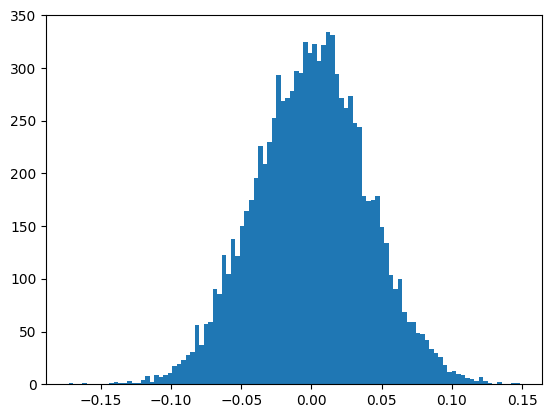

In [250]:
sampling_eps = model.sampling_eps
z_size = model.cfg.model.z_size
var = 16
N = int(1e4)


print(f'Sampling eps: {sampling_eps}')
print(f'Variance: {var}; Std: {np.sqrt(var)}')

z = model.sample(torch.tensor(0).repeat(N, z_size), torch.tensor(var).log().repeat(N, z_size))
plt.hist(z[:, 0].detach().numpy(), bins=100)
plt.show()


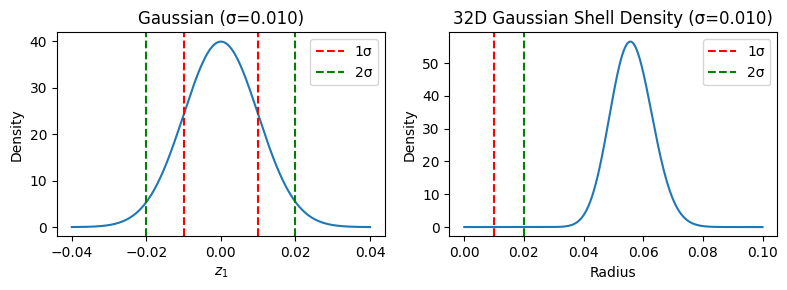

In [17]:
from scipy.special import gamma

sampling_eps = 1e-2  # model.sampling_eps
z_size = model.cfg.model.z_size
var = 1
std_eff = np.sqrt(var)*sampling_eps

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# First subplot - 1D Gaussian
x = np.linspace(-4*std_eff, 4*std_eff, 1000)
gaussian = 1/(std_eff * np.sqrt(2*np.pi)) * np.exp(-0.5*(x/std_eff)**2)

ax1.plot(x, gaussian)
ax1.axvline(x=std_eff, color='r', linestyle='--', label='1σ')
ax1.axvline(x=2*std_eff, color='g', linestyle='--', label='2σ') 
ax1.axvline(x=-std_eff, color='r', linestyle='--')
ax1.axvline(x=-2*std_eff, color='g', linestyle='--')
ax1.legend()
ax1.set_xlabel('$z_1$')
ax1.set_ylabel('Density')
ax1.set_title(f'Gaussian (σ={std_eff:.3f})')

# Second subplot - ND Gaussian shell density
r = np.linspace(0, 10*std_eff, 1000)  # Radius values up to 6 sigma
density = (r**(z_size-1) * np.exp(-r**2/(2*std_eff**2))) / (std_eff**z_size * 2**(z_size/2-1) * gamma(z_size/2))

ax2.plot(r, density)
ax2.axvline(x=std_eff, color='r', linestyle='--', label='1σ')
ax2.axvline(x=2*std_eff, color='g', linestyle='--', label='2σ')
ax2.set_xlabel('Radius')
ax2.set_ylabel('Density')
ax2.set_title(f'{z_size}D Gaussian Shell Density (σ={std_eff:.3f})')
ax2.legend()

plt.tight_layout()
plt.show()


## Closer analysis of neighbourhood expression decoding (old)

In [4]:
from parsing import logits_to_infix, eval_from_logits

In [5]:
i = 4
val_orig = data_from_loader(train_loader, 'values', idx=i)
x = data_from_loader(train_loader, 'x', idx=i)
n_samples = 100
var_multiplier = 16
mean, ln_var = model.encoder(x)
ln_var = ln_var + torch.log(torch.ones_like(ln_var) * var_multiplier)
z = model.sample(mean.repeat(n_samples, 1), ln_var.repeat(n_samples, 1))
logits_neigh = model.decoder(z)

In [6]:
sp.sympify(logits_to_infix(x.squeeze(), sample=False, replace_const='numerical_rounded').lower())


1.13334139153027*x1**2 + x1 + 0.4293

Plot all evaluated samples (maybe with filters)

In [7]:
exprs = []
vals = []
for logits in logits_neigh:
    infix_str = logits_to_infix(logits, sample=True, replace_const='numerical_rounded', round_const_decimals=2)

    try:
        infix_str_simpyfied = sp.sympify(infix_str.lower())
        infix_raw = eval_from_logits(logits, val_x.squeeze())
        infix_raw = infix_raw.astype(np.float32)
    except TypeError:
        pass
    exprs.append([infix_str, infix_str_simpyfied])
    vals.append(infix_raw)

# plt.plot(val_x.squeeze(), np.array([out[j][2] for j in range(len(out))]).T)

In [11]:
values_pred = value_transform(torch.tensor(vals)).detach().numpy()
first_derivative = np.diff(values_pred, axis=1) / np.diff(val_x, axis=0).T
second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
third_derivative = np.diff(second_derivative, axis=1) / np.diff(val_x[:-2], axis=0).T
fourth_derivative = np.diff(third_derivative, axis=1) / np.diff(val_x[:-3], axis=0).T
is_valid = (np.all(np.abs(first_derivative) < 2e2, axis=1) & \
            np.all(np.abs(second_derivative) < 2e2, axis=1) & \
            np.all(np.abs(third_derivative) < 2e2, axis=1) & \
            np.all(np.abs(fourth_derivative) < 2e2, axis=1) & \
            np.all(np.abs(values_pred) < 10, axis=1))

In [12]:
is_valid

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
       False])

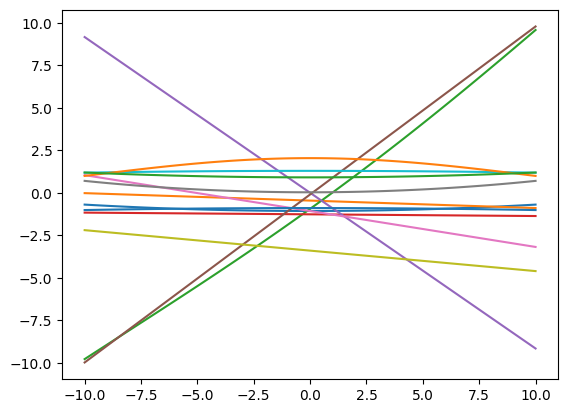

In [13]:
plt.plot(val_x.squeeze(), values_pred[is_valid, :].T)

Compare simplified sampled expressions (might want the non-simplified ones, too)

In [12]:
const_idx = np.where(np.array(syntax_cats) == 'CON')[0]

prod_idx = torch.argmax(logits_neigh[:, :, :-1], dim=-1)
prod_idx_unique = torch.unique(prod_idx, dim=0)

invalid = 0
out = []
for prod_idx_here in prod_idx_unique:
    mask = torch.all(prod_idx == prod_idx_here, dim=1)  # Mask for all samples with same production rule
    logits = logits_neigh[np.where(mask)[0][0], ...].squeeze()
    
    infix_str = logits_to_infix(logits, sample=True, replace_const='numerical_rounded', round_const_decimals=2)
    infix_str_simpyfied = sp.sympify(infix_str.lower())

    infix_raw = eval_from_logits(logits, val_x.squeeze())
    try:
        infix_raw = infix_raw.astype(np.float32)
    except TypeError:
        invalid += 1
        infix_raw = np.zeros_like(infix_raw, dtype=np.float32)
    values_pred = value_transform(torch.tensor(infix_raw))

    out.append([infix_str, infix_str_simpyfied, values_pred])
    
print(f'Unique expressions: {len(out)} out of {n_samples}; Invalid: {invalid}')

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_14675/3645552905.py:17: RuntimeWarning: overflow encountered in cast
  res = res_raw.astype(np.float32)


Unique expressions: 64 out of 100; Invalid: 0


In [23]:
j = 9
out[j][1]

0.0972957470895328*exp(cos(cos(x1))) - cos(cos(exp(x1)))

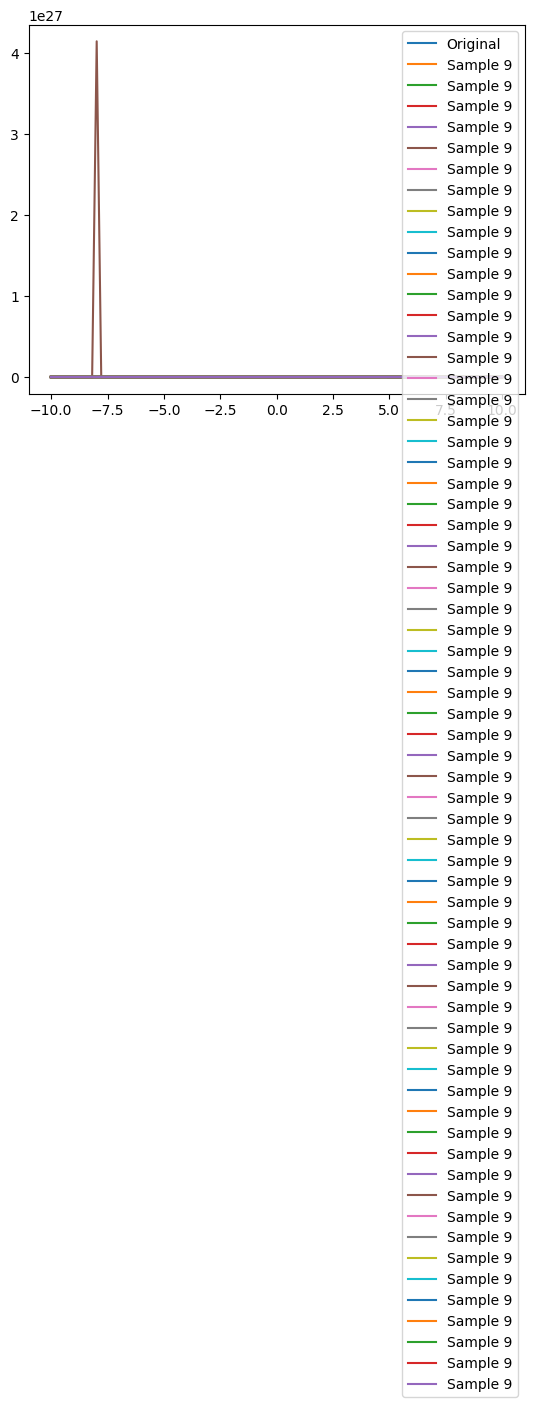

In [24]:
val_orig = data_from_loader(train_loader, 'values', idx=i)
plt.plot(val_x.squeeze(), val_orig.squeeze().detach().numpy(), label='Original')
plt.plot(val_x.squeeze(), np.array([out[j][2] for j in range(len(out))]).T, label=f'Sample {j}')
plt.legend()
plt.show()

In [25]:
for infix_raw, b in infix_raw:
    print(b)


TypeError: cannot unpack non-iterable numpy.float32 object

In [26]:
const_idx = np.where(np.array(syntax_cats) == 'CON')[0]

prod_idx = torch.argmax(logits_neigh[:, :, :-1], dim=-1)
prod_idx_unique = torch.unique(prod_idx, dim=0)
for prod_idx_here in prod_idx_unique:
    mask = torch.all(prod_idx == prod_idx_here, dim=1)
    if (cnt := sum(mask)) > 0:

        infix_str = logits_to_infix(logits_neigh[np.where(mask)[0][0], ...].squeeze(), sample=False, replace_const='placeholder')
        print(f'-- Expression: {infix_str}; Simplified: {sp.sympify(infix_str.lower())}')
        print(f'Number of samples: {cnt}')

        tmp = np.where(prod_idx_here == const_idx)[0]
        for j, const_pos in enumerate(tmp):

            consts = logits_neigh[mask, const_pos, -1]
            consts_mean = consts.mean(dim=0).item()
            consts_std = consts.std(dim=0).item()
            const_min = consts.min(dim=0).values.item()    
            const_max = consts.max(dim=0).values.item()

            print(f'CON_{j}: Mean: {consts_mean:.2f}; Std: {consts_std:.2f}; Min: {const_min:.2f}; Max: {const_max:.2f}; Unique: {len(consts.unique())}')

-- Expression: ((EXP(COS(COS(CON_0)))*CON_1)/CON_2)-COS(CON_3); Simplified: con_1*exp(cos(cos(con_0)))/con_2 - cos(con_3)
Number of samples: 1
CON_0: Mean: 2.43; Std: nan; Min: 2.43; Max: 2.43; Unique: 1
-- Expression: ((CON_0*COS(x1))/CON_1)-COS(COS(COS(CON_2))); Simplified: con_0*cos(x1)/con_1 - cos(cos(cos(con_2)))
Number of samples: 1
CON_0: Mean: -0.00; Std: nan; Min: -0.00; Max: -0.00; Unique: 1
CON_1: Mean: 2.24; Std: nan; Min: 2.24; Max: 2.24; Unique: 1
-- Expression: (COS(EXP(COS(x1)))/CON_0)-CON_1; Simplified: -con_1 + cos(exp(cos(x1)))/con_0
Number of samples: 1
CON_0: Mean: 2.21; Std: nan; Min: 2.21; Max: 2.21; Unique: 1
CON_1: Mean: -0.01; Std: nan; Min: -0.01; Max: -0.01; Unique: 1
-- Expression: (COS(EXP(COS(x1)))/CON_0)-(CON_1-COS(CON_2)); Simplified: -con_1 + cos(con_2) + cos(exp(cos(x1)))/con_0
Number of samples: 1
CON_0: Mean: 2.30; Std: nan; Min: 2.30; Max: 2.30; Unique: 1
-- Expression: (COS(COS(COS(x1))-CON_0))-COS(CON_1); Simplified: -cos(con_1) + cos(con_0 - cos

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_14675/3364203915.py:18: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  consts_std = consts.std(dim=0).item()


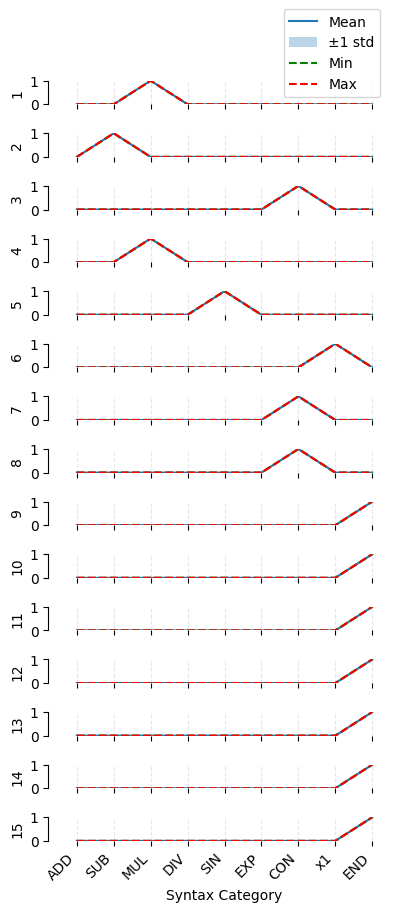

In [27]:
import torch.nn.functional as F

n = 0
i = 0
N = 16
x = data_from_loader(train_loader, 'x', idx=range(i, i+N))

# Encode into latent space
mean, ln_var = model.encoder(x)
logits = model.decoder(mean, max_length=15)
values = model.value_decoder(mean)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = model.sample(mean, ln_var)  # Sample from neighbourhood in latent space
    logits = model.decoder(z, max_length=15)
    samples.append(logits.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2, 3)
syntax_samples = samples[:, :, :, :-1]
syntax_samples = F.softmax(torch.tensor(syntax_samples), dim=-1).numpy()
consts_samples = samples[:, :, :, -1]

mean_samples = np.mean(syntax_samples, axis=1)
std_samples = np.std(syntax_samples, axis=1)
min_samples = np.min(syntax_samples, axis=1)
max_samples = np.max(syntax_samples, axis=1)

fig, axes = plt.subplots(mean_samples.shape[1], 1, figsize=(4, 0.6*mean_samples.shape[1]), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove vertical space between subplots
for i in range(mean_samples.shape[1]):
    axes[i].plot(mean_samples[n, i, :], label='Mean')
    axes[i].fill_between(range(mean_samples.shape[2]),
                         mean_samples[n, i, :] - std_samples[n, i, :],
                         mean_samples[n, i, :] + std_samples[n, i, :],
                         alpha=0.3, label='±1 std')
    axes[i].plot(min_samples[n, i, :], label='Min', linestyle='--', color='green')
    axes[i].plot(max_samples[n, i, :], label='Max', linestyle='--', color='red')
    axes[i].set_xticks(range(len(syntax_cats)))
    axes[i].set_xticklabels(syntax_cats, rotation=45, ha='right')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3)
    axes[i].set_ylim(0, 1)  # Set y-limit between 0 and 1
    axes[i].set_ylabel(f'{i+1}')  # Add y-label showing timestep
    if i == mean_samples.shape[1] - 1:
        axes[i].set_xlabel('Syntax Category')
    if i == 0:
        axes[i].legend()
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['bottom'].set_visible(False)  # Remove bottom border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_position(('outward', 10))  # Move left spine outward

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Reduce right margin
plt.show()